### 0. Packages

In [63]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np 
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
import os
import json
import geopandas as gpd
import matplotlib as mpl

#import fasttext 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import string
import math
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import mannwhitneyu

from data_wrangling.cmu_wrangling import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Importing data

In [2]:
CMU = get_CMU()

In [3]:
Horror_movies, merged_df = get_Horror_movies_and_merged_df(CMU)

In [4]:
CMU.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'}, inplace=True)
Horror_movies.rename(columns={'Weekipedia_ID': 'Wikipedia movie ID'}, inplace=True)

In [5]:
df_hist = get_df_hist(merged_df)

In [27]:
merged, triggers = get_merged_and_triggers(Horror_movies)

In [7]:
print('Number of movies in horror dataset :', len(Horror_movies))
print('Number of common movies :',len(merged))

Number of movies in horror dataset : 34955
Number of common movies : 10226


# 2. Analysis

In [8]:
plt.style.use('dark_background')

## 2.1 Horror Movie Metadata Analysis

This first part of the analysis aims to take a quick look at the datasets and evaluate the number of nans.
In addition, it aims to find specificities in the 'metadata' of horror movies as compared to other genres.
More concretely, this part of the code looks at the distribution of movie release over the years and at the countries that produce most of the movies.

In [33]:
from analysis.horror_movie_metadata import *

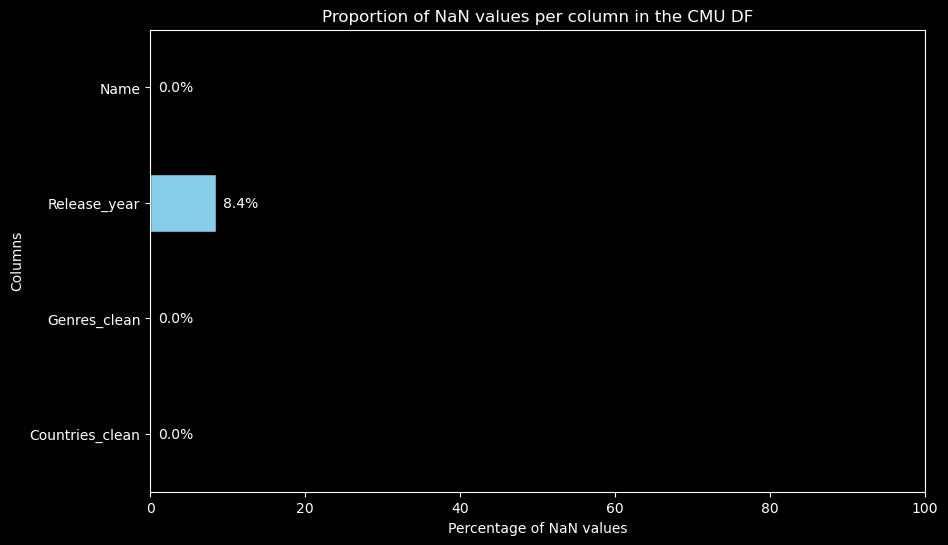

In [28]:
plot_nan_proportion(CMU, 'CMU', columns=['Name', 'Release_year','Genres_clean', 'Countries_clean'])

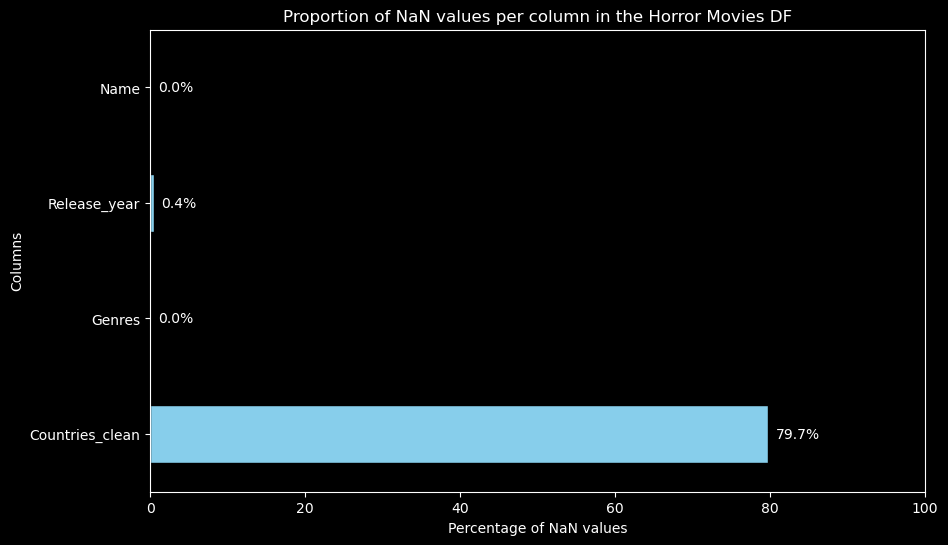

In [29]:
plot_nan_proportion(Horror_movies, 'Horror Movies', columns=['Name', 'Release_year','Genres', 'Countries_clean'])

These plots show that there are many missing values for the countries in the horror movie data set, due to the additional dataset. Thus, we will need to be careful in further analyses of the countries.

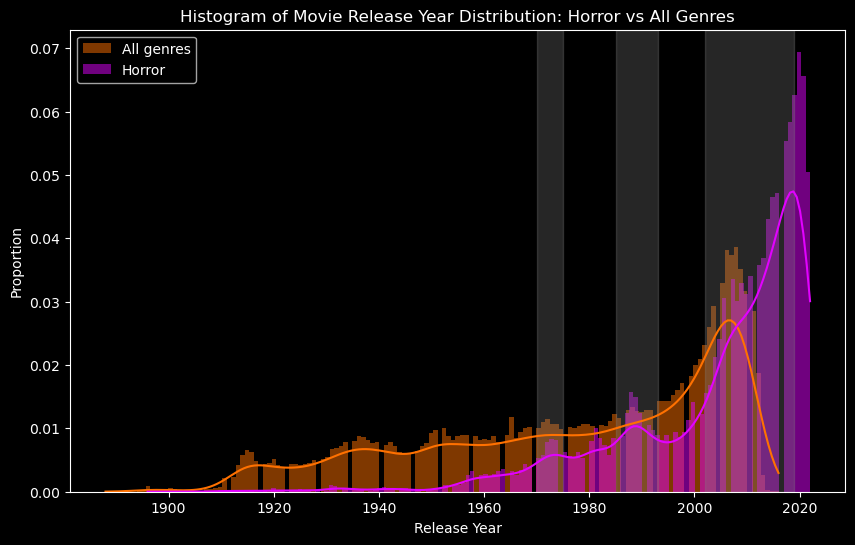

In [12]:
plot_movies_distribution_hist(CMU, Horror_movies)

In [13]:
# statistical test
ks_statistic, p_value = stats.ks_2samp(CMU['Release_year'].dropna(), Horror_movies['Release_year'].dropna())

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

alpha = 0.05  
if p_value < alpha:
    print("The distributions are significantly different.")
else:
    print("The distributions are not significantly different.")


KS Statistic: 0.46549518536894285
P-value: 0.0
The distributions are significantly different.


Taking a first look at the distribution of movie release across the years allows to see that there are some differences between horror movies and other movies. In addition, some peaks are visible on the graph and it would be interesting to further investigate if these peaks are due to some historical or societal events.

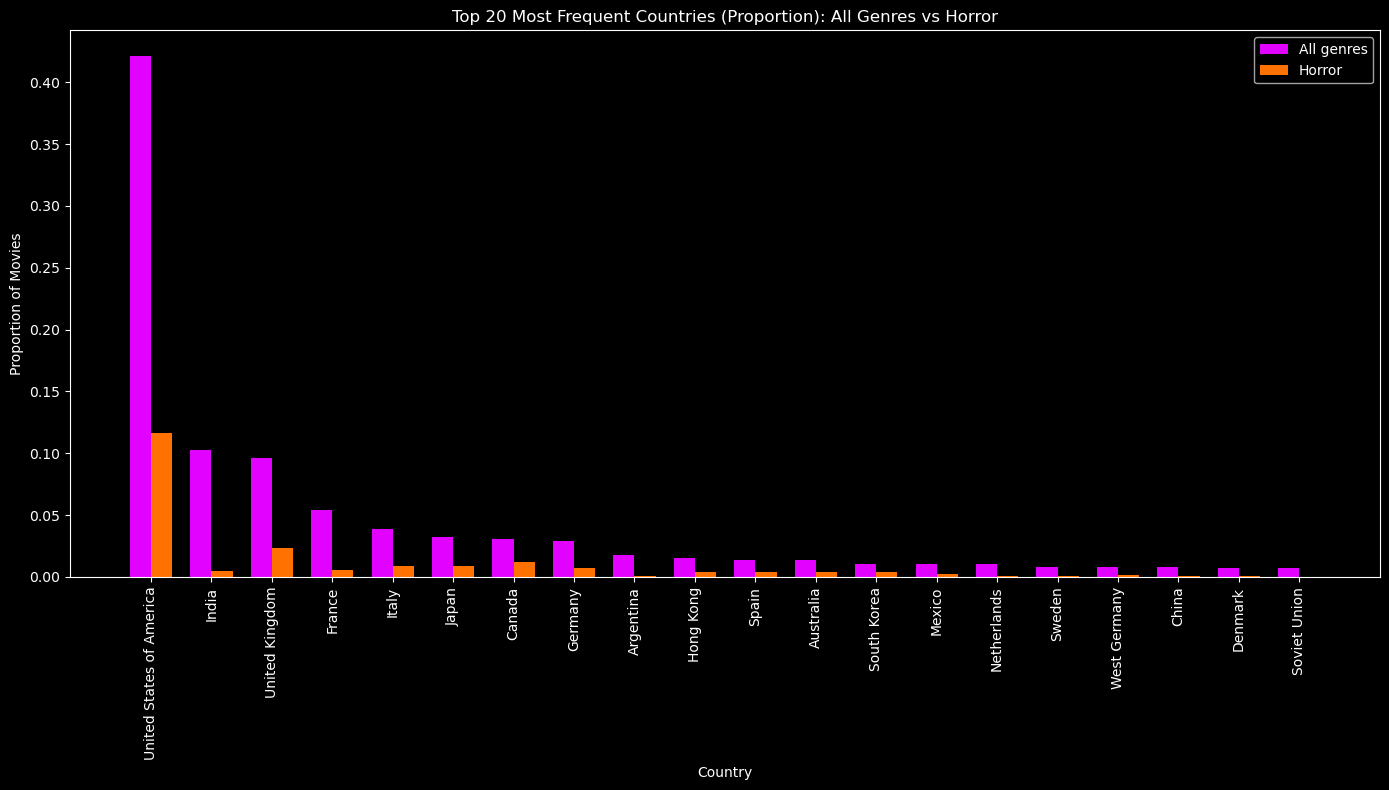

In [ ]:
# COMPARE THE COUNTRIES IN WHICH THE MOVIES WHERE PRODUCED
plot_movies_countries_distribution(CMU, Horror_movies)

The chart reveals that very few countries produce a substantial proportion of horror movies, with the United States being the clear leader. While many countries have significant film industries across all genres (indicated by the purple bars), the orange bars for horror are much smaller or nearly absent in most countries. This suggests that horror is a niche genre in many parts of the world, and its distribution does not mirror that of general film production. The U.S. stands out as the primary contributor to horror, while other countries produce fewer horror films relative to their overall output.
It would be interesting to further investigate why this is the case

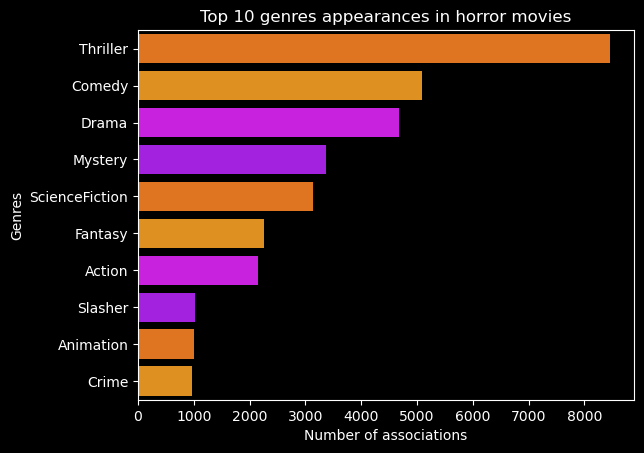

In [26]:
plot_most_represented_associated_genres(Horror_movies)

In this plot we can see the most represented genres in link with horror movies. As expected Thriller, Comedy and Drama are the top three. Surprinsingly, Crime is only placed at the 10th place.

Mann-Whitney U test's pvalue is 0.0063873670253678716, which is significative


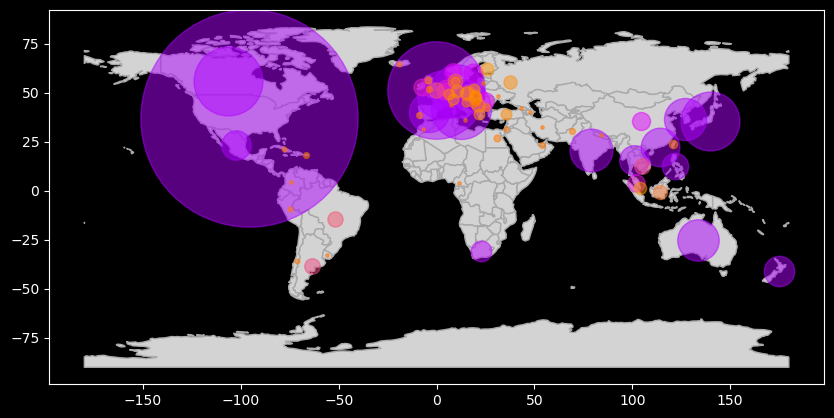

In [36]:
plot_movies_world_map(Horror_movies)
stat, pvalue = testing_occidental_countries(Horror_movies)
print(f"Mann-Whitney U test's pvalue is {pvalue}, which is significative")

In this world map, we can observe the locations where horror films are produced. The robust Mann-Whitney test reveals a significant difference in rankings between Occidental and non-Occidental countries. Clearly, the USA and Europe are major production hubs in Occidental countries. In contrast, highly populated non-Occidental countries such as India and China are among the largest producers, as expected. Japan and Korea, however, stand out as outliers due to their highly developed and influential cinematic industries.

## 2.2 Actor profile

In [59]:
from analysis.actor_profile import *

This part of the code aims to take a look at the gender and ethnicity of the actors and compare the distribution between horror movies and other genres to see if there is a significant difference.

In [44]:
# merge actors with movies
Horror_movies_with_actors = get_df_with_actors(Horror_movies)
CMU_with_actors = get_df_with_actors(CMU)

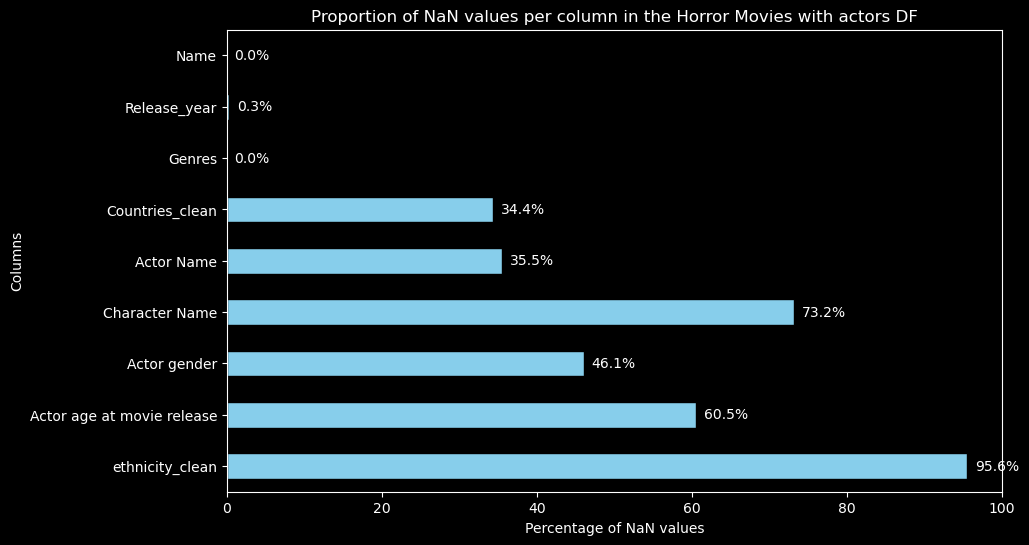

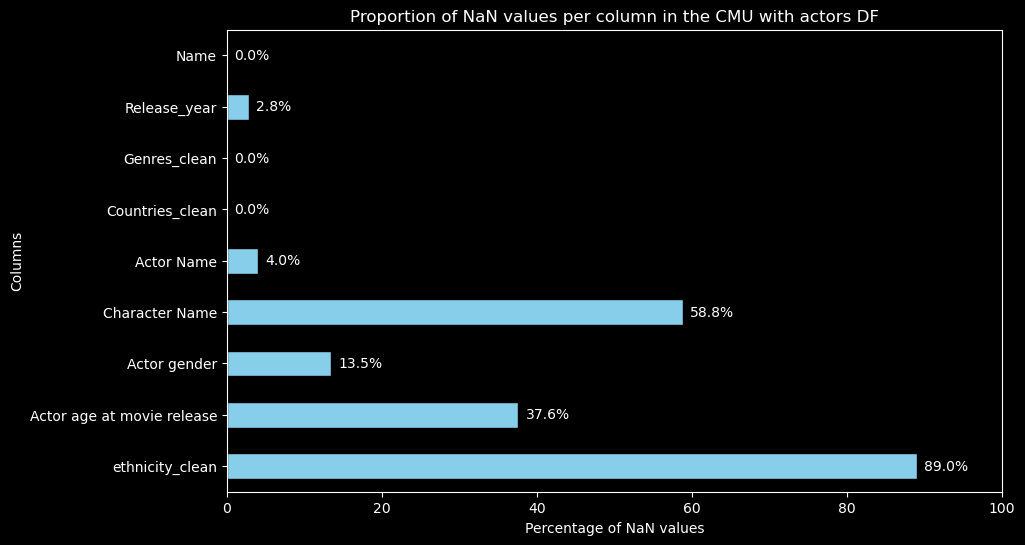

In [45]:
plot_nan_proportion(Horror_movies_with_actors, 'Horror Movies with actors' ,columns=['Name', 'Release_year','Genres', 'Countries_clean', 'Actor Name', 'Character Name', 'Actor gender','Actor age at movie release', 'ethnicity_clean'])
plot_nan_proportion(CMU_with_actors, 'CMU with actors', columns=['Name', 'Release_year','Genres_clean', 'Countries_clean', 'Actor Name','Character Name', 'Actor gender','Actor age at movie release', 'ethnicity_clean'])

We can see that there is a significant amount of missing values, especially for the actor ethnicity, we will need to make sure that the results can still be used and are significant.

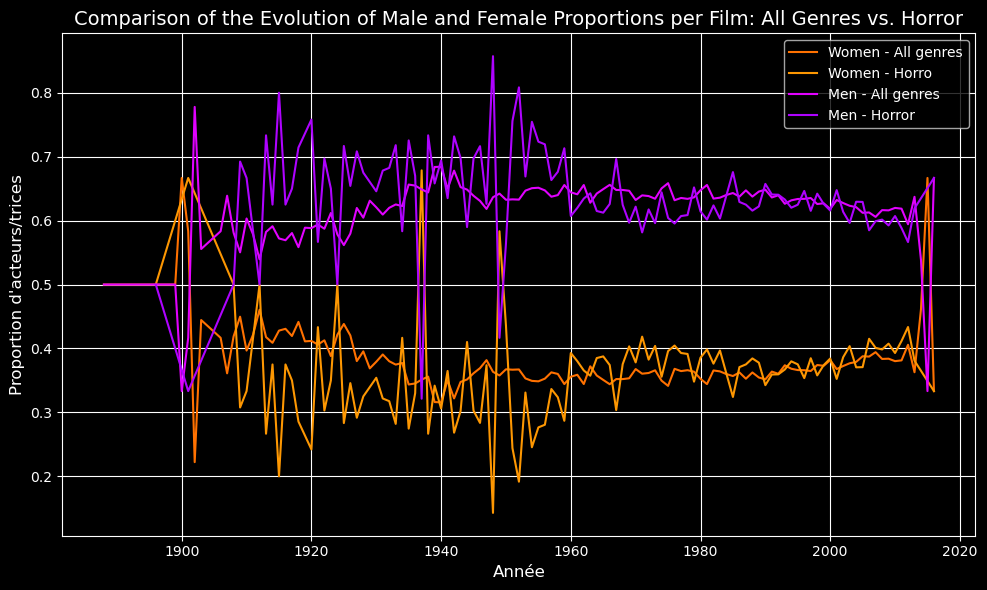

In [52]:

# LOOK AT PROPORTION OF MEN AND WOMEN IN MOVIES OVER THE YEARS AND COMPARE HORROR AND ALL GENRES
CMU_mean_women_proportion, CMU_mean_men_proportion = compute_gender_proportions(CMU_with_actors)
Horror_mean_women_proportion, Horror_mean_men_proportion = compute_gender_proportions(Horror_movies_with_actors)

plot_men_women_proportions(CMU_mean_women_proportion, CMU_mean_men_proportion,
                            Horror_mean_women_proportion, Horror_mean_men_proportion)

In all genres, the gender distribution seems quite constant across the years (approx. 60% men and 40% women). However, in horror movies, the proportions seem more variable until the 1960's. We could further investigate whether this could be linked with the rise of feminism in the 1960's.

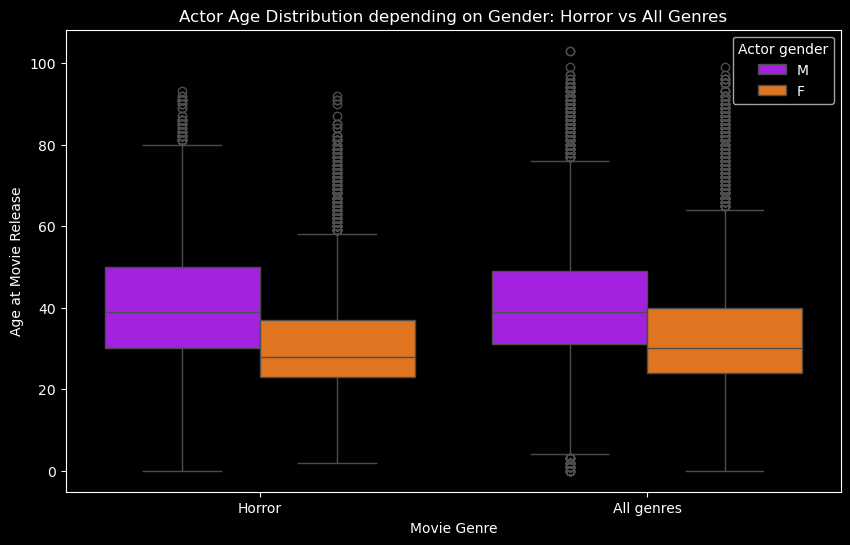

In [56]:
# VERIFY IF THERE IS A DIFFERENCE IN THE AGE OF ACTORS BETWEEN MEN AND WOMEN AND BETWEEN HORROR AND ALL GENRES
plot_age_differences_women_men(Horror_movies_with_actors, CMU_with_actors)

This plot does not seem to show very signicant differences in terms of actor age depending on actor gender or movie genre.

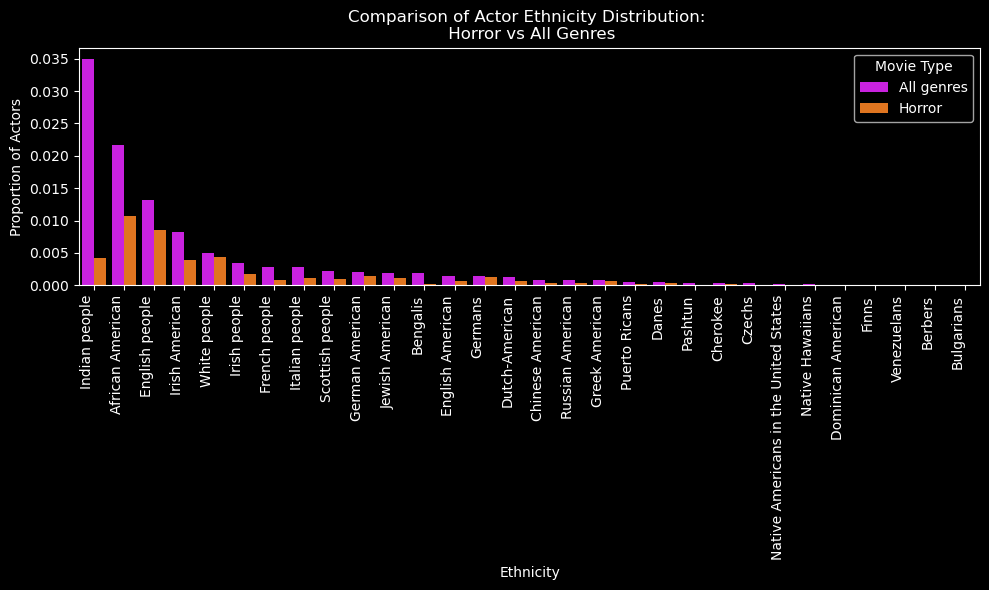

In [60]:
# LOOK AT ACTOR ETHNICITY DISTRIBUTION AND COMPARE BETWEEN HORROR AND ALL GENRES
plot_ethnicity_actors(Horror_movies_with_actors, CMU_with_actors)

This plot shows that the most frequent actor ethnicities are not the same in horror movies as compared to other genres. We could further investigate if there is a correlation with the character types.

## 2.3 Tropes

In [69]:
from analysis.tropes import *

This part of the code aims to take a first look at the tropes dataset and see if there are some specific profiles (gender, ethicity, etc.) for some of the tropes.
As shown below the tropes dataset only covers a very small part of the dataset. To further investigate tropes, we would need to find another dataset or use maybe use ChatGPT to find the 'character types' of the actors with missing information. Alternatively, looking at the summaries could also be an option to find information about 'character types'.

In [ ]:
# LOAD AND PROCESS THE TROPES DF
tv_tropes = get_tv_tropes()

In [65]:
# merge tropes with actors and movies
Horror_movies_with_actors_tropes = get_df_with_tv_tropes(Horror_movies_with_actors, tv_tropes)
CMU_with_actors_tropes = get_df_with_tv_tropes(CMU_with_actors, tv_tropes)

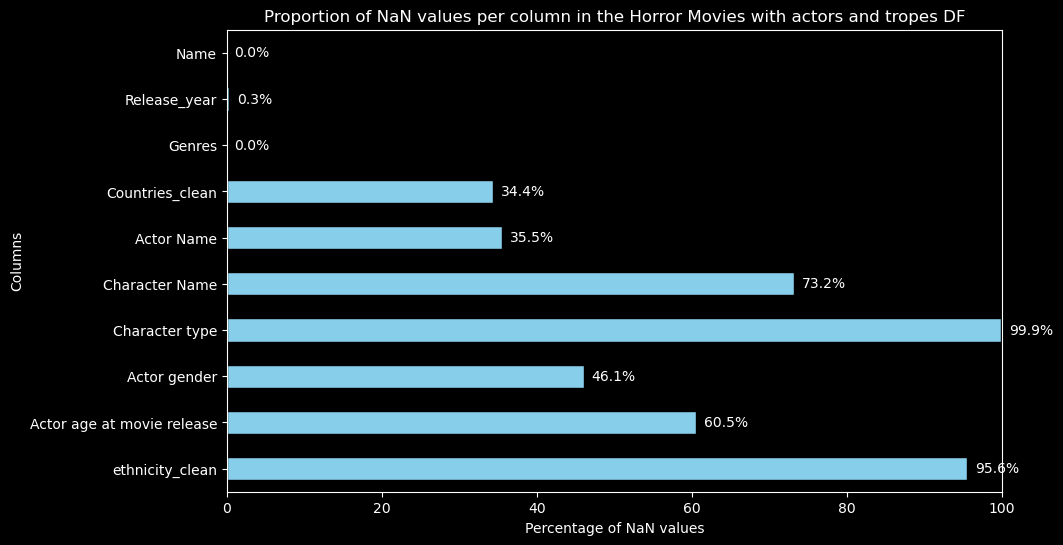

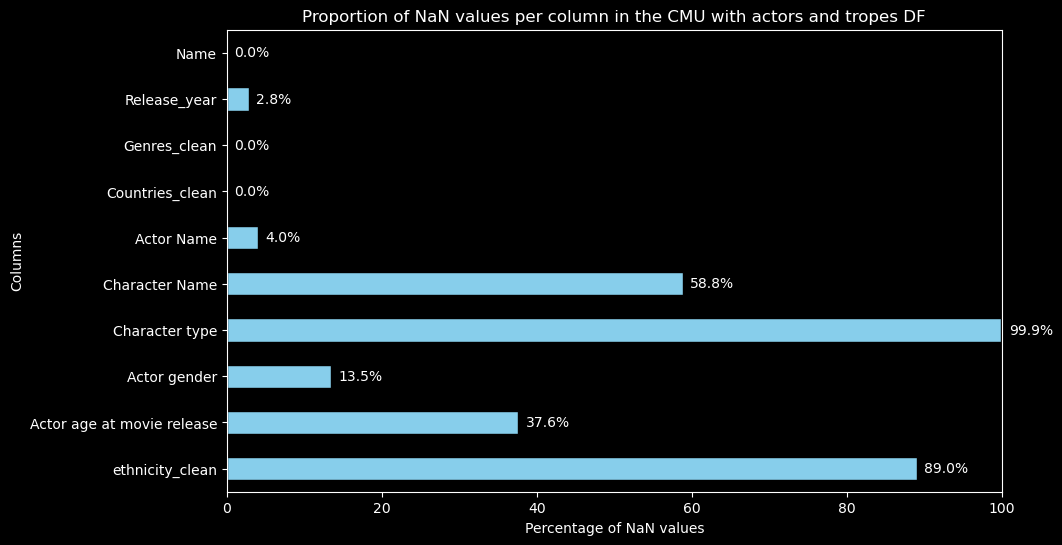

In [66]:
# nan diagnostic
plot_nan_proportion(Horror_movies_with_actors_tropes, 'Horror Movies with actors and tropes' ,columns=['Name', 'Release_year','Genres', 'Countries_clean', 'Actor Name', 'Character Name', 'Character type', 'Actor gender','Actor age at movie release', 'ethnicity_clean'])
plot_nan_proportion(CMU_with_actors_tropes, 'CMU with actors and tropes', columns=['Name', 'Release_year','Genres_clean', 'Countries_clean', 'Actor Name','Character Name', 'Character type','Actor gender','Actor age at movie release', 'ethnicity_clean'])


As mentionned above, almost all the movies and actors lack trope information.

In [67]:
#first look at tropes in horror movie df
Horror_movies_with_actors_tropes['Character type'].value_counts()

Character type
final_girl                     11
father_to_his_men               5
jerk_jock                       5
corrupt_corporate_executive     3
crazy_jealous_guy               3
dumb_blonde                     3
egomaniac_hunter                2
klutz                           2
valley_girl                     1
stoner                          1
crazy_survivalist               1
absent_minded_professor         1
cultured_badass                 1
charmer                         1
bully                           1
coward                          1
ophelia                         1
bromantic_foil                  1
brainless_beauty                1
slacker                         1
morally_bankrupt_banker         1
broken_bird                     1
master_swordsman                1
granola_person                  1
bruiser_with_a_soft_center      1
henpecked_husband               1
heartbroken_badass              1
Name: count, dtype: int64

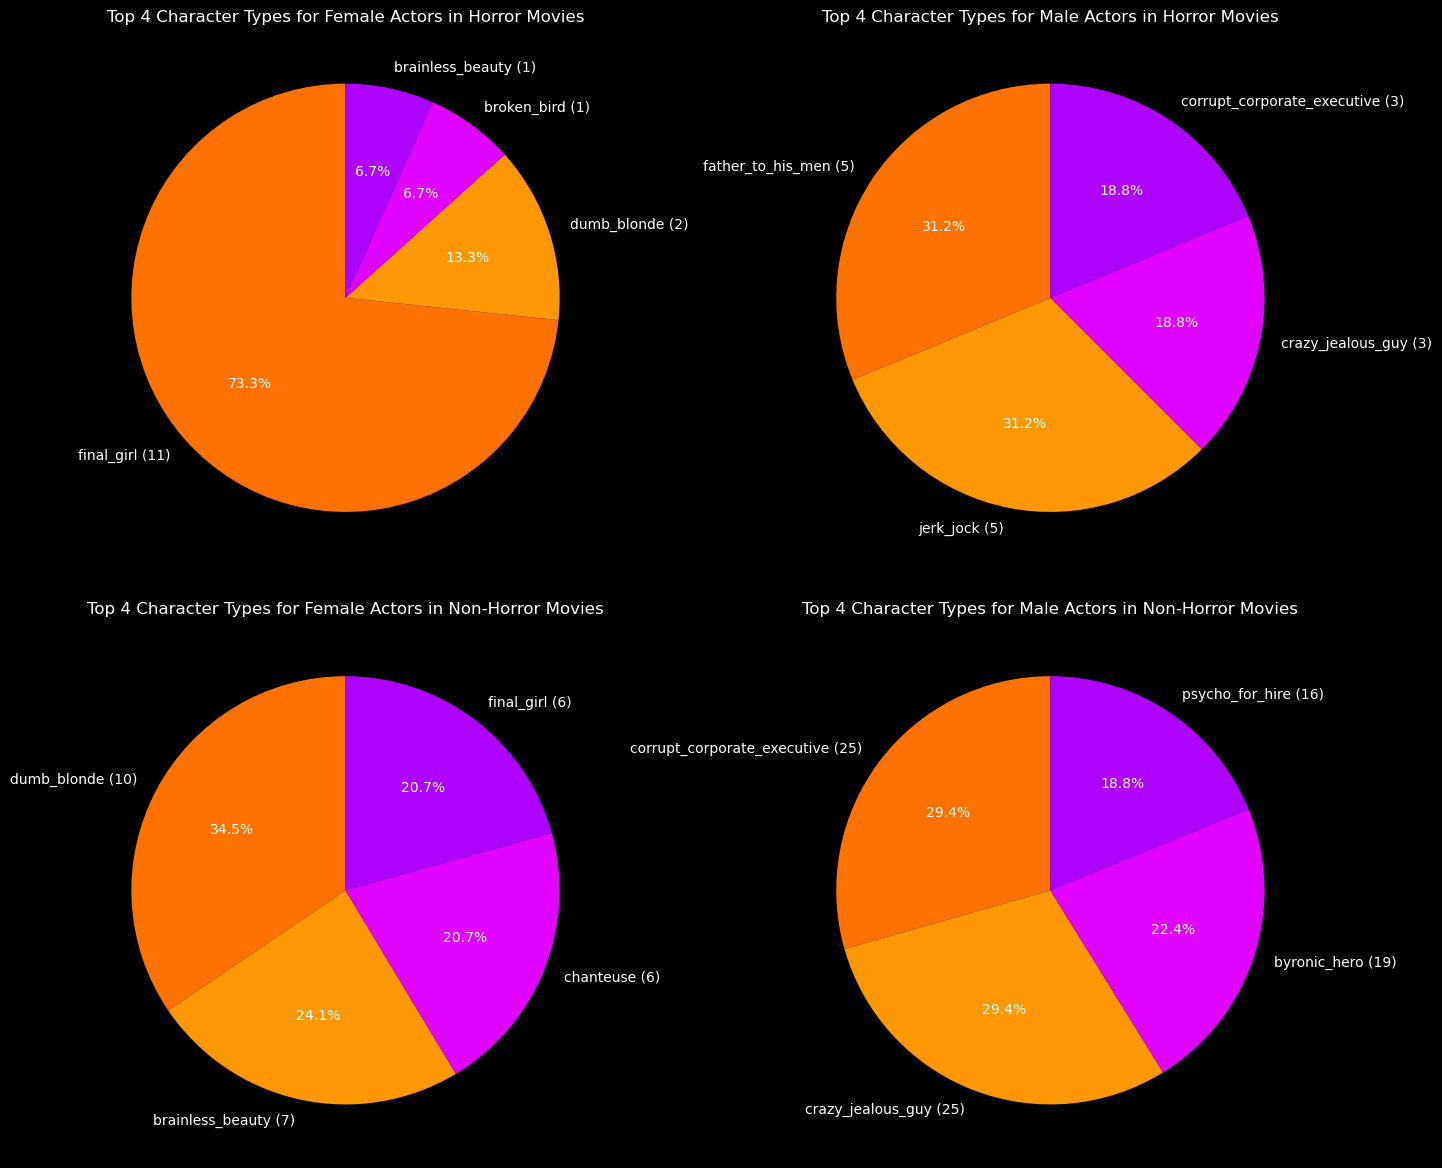

In [71]:
# TAKE A LOOK AT THE TROPES DEPENDING ON GENRE, GENDER, ETHNICITY ETC.
plot_top4_types(Horror_movies_with_actors_tropes, CMU_with_actors_tropes)

The results are interesting but clearly not significant with this amount of information.

In [ ]:
get_character_count(Horror_movies_with_actors_tropes, 'ethnicity_clean', 'African American', 10, 'Top Character Types for African American Actors in Horror Movies', plot=True)
get_character_count(CMU_with_actors_tropes, 'ethnicity_clean', 'African American', 10, 'Top Character Types for African American Actors in All Types of Movies', plot=True)

get_character_count(Horror_movies_with_actors_tropes, 'ethnicity_clean', 'English people', 10, 'Top Character Types for English Actors in Horror Movies', plot=True)
get_character_count(CMU_with_actors_tropes, 'ethnicity_clean', 'African American', 10, 'Top Character Types for African American Actors in All Types of Movies', plot=True)


## 2.4 Triggers

In [33]:
custom_palette = [
    "#ff6f00",  # Orange ajusté
    "#fc8c02",  # Orange différent
    "#e000ff",  # Magenta ajusté
    "#a302ff",  # Violet ajusté
    "#1a1a1a",  # Noir adouci (gris foncé)
    "#00b3ff",  # Cyan vif
    "#f5e942",  # Jaune éclatant
    "#4cff00",  # Vert néon
    "#ff0073",  # Rose vif
    "#6a0dad",  # Violet profond
    "#ff4500",  # Rouge-orangé éclatant
    "#00ff7f",  # Vert printemps
    "#8b00ff",  # Violet
    "#ffd700",  # Or
    "#1e90ff",  # Bleu dodger
    "#ff1493",  # Rose foncé
    "#32cd32",  # Vert lime
    "#ff6347",  # Tomate
    "#40e0d0",  # Turquoise
    "#ffcccb"   # Corail clair
]

In [34]:
merged = merged.dropna(subset=['Date'])
merged = merged.replace(0, np.nan)
merged = merged[merged['Date'] > 1950]
trigger_counts = merged.groupby('Date').sum()

In [ ]:
compte = merged.groupby('Date').size().reset_index(name='count')
plt.figure(figsize=(10, 6))
plt.bar(compte['Date'], compte['count'], color=custom_palette[3])
plt.xlabel('Year')
plt.style.use('dark_background')
plt.ylabel('Number of movies')
plt.title('Number of movies per year')
plt.xticks(rotation=45)  
plt.show()

This dataset was created merging the trigger dataset found on Doesthedogdie.com, and the common horror dataset used for the rest of the analysis. This allowed us to extract the horror content of the trigger dataset. For this part, we then use a dataset of 10 226 horror movies between 1950 and 2024.

### Analysis of content

In [ ]:
fig, axs = plt.subplots(7, 3, figsize=(20, 30))  
plt.style.use('dark_background')

triggers_to_plot1 = ["a child is abandoned by a parent or guardian", "an animal is abandoned"]
for i, trigger in enumerate(triggers_to_plot1):
    axs[0, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 0].set_ylabel("Number of movies with this element")
axs[0, 0].set_title("Abandonment")
axs[0, 0].legend()

triggers_to_plot2 = ["there's abusive parents"]
for i, trigger in enumerate(triggers_to_plot2):
    axs[0, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 1].set_title("Familial violences")
axs[0, 1].legend()

triggers_to_plot3 = ["there's addiction", "someone uses drugs", "someone overdoses"]
for i, trigger in enumerate(triggers_to_plot3):
    axs[0, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 2].set_title("Addiction")
axs[0, 2].legend()

triggers_to_plot4 = ["rape is mentioned", "sexual assault on men is a joke", "someone is restrained", "someone is held under water", "someone is beaten up by a bully", "someone's mouth is covered"]
for i, trigger in enumerate(triggers_to_plot4):
    axs[1, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 0].set_ylabel("Number of movies with this element")
axs[1, 0].set_title("Violences")
axs[1, 0].legend()

triggers_to_plot5 = ["there's excessive gore", "there's genital trauma/mutilation", "there's torture", "heads get squashed", "teeth are damaged", "there's finger/toe mutilation", "there's body horror", "someone is burned alive", "there's cannibalism", "someone's throat is mutilated", "someone is crushed to death"]
for i, trigger in enumerate(triggers_to_plot5):
    axs[1, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 1].set_title("Bloody Violences")
axs[1, 1].legend()

triggers_to_plot6 = ["a kid dies", "an infant is abducted"]
for i, trigger in enumerate(triggers_to_plot6):
    axs[1, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 2].set_title("Children")
axs[1, 2].legend()

triggers_to_plot7 = ["a non-human character dies", "a major character dies", "someone dies", "someone sacrifices themselves"]
for i, trigger in enumerate(triggers_to_plot7):
    axs[2, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 0].set_title("Death")
axs[2, 0].legend()

triggers_to_plot8 = ["a kid dies", "someone dies"]
for i, trigger in enumerate(triggers_to_plot8):
    axs[2, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 1].set_title("Total death & child death")
axs[2, 1].legend()

triggers_to_plot9 = ["someone disabled played by able-bodied", "the r-slur is used"]
for i, trigger in enumerate(triggers_to_plot9):
    axs[2, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 2].set_title("Disabiltiy")
axs[2, 2].legend()

triggers_to_plot10 = ["there are jump scares", "someone is possessed", "there are clowns", "there are shower scenes", "there's ghosts", "there are mannequins", "there's natural bodies of water"]
for i, trigger in enumerate(triggers_to_plot10):
    axs[3, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 0].set_ylabel("Number of movies with this element")
axs[3, 0].set_title("Fears")
axs[3, 0].legend()

triggers_to_plot11 = ["There's audio gore", "someone is eaten", "someone wets/soils themselves", "there's farting", "there's spitting", "someone poops on-screen", "someone vomits"]
for i, trigger in enumerate(triggers_to_plot11):
    axs[3, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 1].set_title("Disgust")
axs[3, 1].legend()

triggers_to_plot12 = ["there are 9/11 depictions", "there's incarceration"]
for i, trigger in enumerate(triggers_to_plot12):
    axs[3, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 2].set_title("Crimes")
axs[3, 2].legend()

colonnes_interval13 = trigger_counts.loc[:, 'a trans person is depicted predatorily': "there's bisexual cheating"]
triggers_to_plot13 = colonnes_interval13.columns.tolist()
for i, trigger in enumerate(triggers_to_plot13):
    axs[4, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 0].set_ylabel("Number of movies with this element")
axs[4, 0].set_title("LGBTQ+")
axs[4, 0].legend()

triggers_to_plot14 = ["needles/syringes are used", "someone has an eating disorder", "a mentally ill person is violent", "there's misophonia", "autism is misrepresented", "there's body dysmorphia", "someone has an anxiety attack", "reality is unstable or unhinged", "there's dissociation, depersonalization, or derealization", "D.I.D. Misrepresentation", "there's a claustrophobic scene", "someone has a mental illness", "someone self harms", "Someone attempts suicide", "someone dies by suicide"]
for i, trigger in enumerate(triggers_to_plot14):
    axs[4, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[4, 1].set_title("Medical")
axs[4, 1].legend()

triggers_to_plot15 = ["there's flashing lights or images", "shaky cam is used", "there are sudden loud noises", "there's screaming", "there is obscene language/gestures"]
for i, trigger in enumerate(triggers_to_plot15):
    axs[4, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[4, 2].set_title("Distressing systems")
axs[4, 2].legend()

triggers_to_plot16 = ["someone has an abortion", "a pregnant person dies", "there's childbirth", "someone miscarries", "there is a baby or unborn child", "a baby is stillborn"]
for i, trigger in enumerate(triggers_to_plot16):
    axs[5, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 0].set_ylabel("Number of movies with this element")
axs[5, 0].set_title("Pregnancy")
axs[5, 0].legend()

triggers_to_plot17 = ["there's fat jokes", "there's ableist language or behavior", "someone says the n-word", "an LGBT person dies", "there's antisemitism", "a minority is misrepresented", "the black guy dies first", "someone speaks hate speech", "there are homophobic slurs", "there's blackface","someone is misgendered"]
for i, trigger in enumerate(triggers_to_plot17):
    axs[5, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 1].set_title("Discrimination")
axs[5, 1].legend()

triggers_to_plot18 = ["there's demons or Hell", "religion is discussed"]
for i, trigger in enumerate(triggers_to_plot18):
    axs[5, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 2].set_title("Religion")
axs[5, 2].legend()

triggers_to_plot19 = ["someone has dementia/Alzheimer's", "someone is terminally ill", "someone has a stroke", "someone has a chronic illness"]
for i, trigger in enumerate(triggers_to_plot19):
    axs[6, 0].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 0].set_ylabel("Number of movies with this element")
axs[6, 0].set_title("Disease")
axs[6, 0].legend()

triggers_to_plot20 = ["the ending is sad"]
for i, trigger in enumerate(triggers_to_plot20):
    axs[6, 1].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 1].set_title("Sad end")
axs[6, 1].legend()

triggers_to_plot21 = ["a person is hit by a car", "a car crashes", "a car honks or tires screech", "a plane crashes"]
for i, trigger in enumerate(triggers_to_plot21):
    axs[6, 2].plot(trigger_counts.index, trigger_counts[trigger], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 2].set_title("Transport")
axs[6, 2].legend()

plt.tight_layout()
plt.show()

Here we visualize the number of movies per year that contain specific content. This allows us to compare the apparition of different triggers. Unfortunately, the apparition of each content follows the global repartition of movies per year. To get rid of this bias, we try again but after a standardization (the number of movies with a content is now divided by the total number of movies the same year).

### Standardization

In [ ]:
fig, axs = plt.subplots(7, 3, figsize=(20, 30))  
plt.style.use('dark_background')

triggers_to_plot1 = ["a child is abandoned by a parent or guardian", "an animal is abandoned"]
for i, trigger in enumerate(triggers_to_plot1):
    axs[0, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 0].set_ylabel("Fraction of movies with this element")
axs[0, 0].set_title("Abandonment")
axs[0, 0].legend()

triggers_to_plot2 = ["there's abusive parents"]
for i, trigger in enumerate(triggers_to_plot2):
    axs[0, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 1].set_title("Familial violences")
axs[0, 1].legend()

triggers_to_plot3 = ["there's addiction", "someone uses drugs", "someone overdoses"]
for i, trigger in enumerate(triggers_to_plot3):
    axs[0, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[0, 2].set_title("Addiction")
axs[0, 2].legend()

triggers_to_plot4 = ["rape is mentioned", "sexual assault on men is a joke", "someone is restrained", "someone is held under water", "someone is beaten up by a bully", "someone's mouth is covered"]
for i, trigger in enumerate(triggers_to_plot4):
    axs[1, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 0].set_ylabel("Fraction of movies with this element")
axs[1, 0].set_title("Violences")
axs[1, 0].legend()

triggers_to_plot5 = ["there's excessive gore", "there's genital trauma/mutilation", "there's torture", "heads get squashed", "teeth are damaged", "there's finger/toe mutilation", "there's body horror", "someone is burned alive", "there's cannibalism", "someone's throat is mutilated", "someone is crushed to death"]
for i, trigger in enumerate(triggers_to_plot5):
    axs[1, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 1].set_title("Bloody Violences")
axs[1, 1].legend()

triggers_to_plot6 = ["a kid dies", "an infant is abducted"]
for i, trigger in enumerate(triggers_to_plot6):
    axs[1, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 2].set_title("Children")
axs[1, 2].legend()

triggers_to_plot7 = ["a non-human character dies", "a major character dies", "someone dies", "someone sacrifices themselves"]
for i, trigger in enumerate(triggers_to_plot7):
    axs[2, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 0].set_title("Death")
axs[2, 0].legend()

triggers_to_plot8 = ["a kid dies", "someone dies"]
for i, trigger in enumerate(triggers_to_plot8):
    axs[2, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 1].set_title("Total death & child death")
axs[2, 1].legend()

triggers_to_plot9 = ["someone disabled played by able-bodied", "the r-slur is used"]
for i, trigger in enumerate(triggers_to_plot9):
    axs[2, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[2, 2].set_title("Disabiltiy")
axs[2, 2].legend()

triggers_to_plot10 = ["there are jump scares", "someone is possessed", "there are clowns", "there are shower scenes", "there's ghosts", "there are mannequins", "there's natural bodies of water"]
for i, trigger in enumerate(triggers_to_plot10):
    axs[3, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 0].set_ylabel("Fraction of movies with this element")
axs[3, 0].set_title("Fears")
axs[3, 0].legend()

triggers_to_plot11 = ["There's audio gore", "someone is eaten", "someone wets/soils themselves", "there's farting", "there's spitting", "someone poops on-screen", "someone vomits"]
for i, trigger in enumerate(triggers_to_plot11):
    axs[3, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 1].set_title("Disgust")
axs[3, 1].legend()

triggers_to_plot12 = ["there are 9/11 depictions", "there's incarceration"]
for i, trigger in enumerate(triggers_to_plot12):
    axs[3, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[3, 2].set_title("Crimes")
axs[3, 2].legend()

colonnes_interval13 = trigger_counts.loc[:, 'a trans person is depicted predatorily': "there's bisexual cheating"]
triggers_to_plot13 = colonnes_interval13.columns.tolist()
for i, trigger in enumerate(triggers_to_plot13):
    axs[4, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[1, 0].set_ylabel("Fraction of movies with this element")
axs[4, 0].set_title("LGBTQ+")
axs[4, 0].legend()

triggers_to_plot14 = ["needles/syringes are used", "someone has an eating disorder", "a mentally ill person is violent", "there's misophonia", "autism is misrepresented", "there's body dysmorphia", "someone has an anxiety attack", "reality is unstable or unhinged", "there's dissociation, depersonalization, or derealization", "D.I.D. Misrepresentation", "there's a claustrophobic scene", "someone has a mental illness", "someone self harms", "Someone attempts suicide", "someone dies by suicide"]
for i, trigger in enumerate(triggers_to_plot14):
    axs[4, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[4, 1].set_title("Medical")
axs[4, 1].legend()

triggers_to_plot15 = ["there's flashing lights or images", "shaky cam is used", "there are sudden loud noises", "there's screaming", "there is obscene language/gestures"]
for i, trigger in enumerate(triggers_to_plot15):
    axs[4, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[4, 2].set_title("Distressing systems")
axs[4, 2].legend()

triggers_to_plot16 = ["someone has an abortion", "a pregnant person dies", "there's childbirth", "someone miscarries", "there is a baby or unborn child", "a baby is stillborn"]
for i, trigger in enumerate(triggers_to_plot16):
    axs[5, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 0].set_ylabel("Fraction of movies with this element")
axs[5, 0].set_title("Pregnancy")
axs[5, 0].legend()

triggers_to_plot17 = ["there's fat jokes", "there's ableist language or behavior", "someone says the n-word", "an LGBT person dies", "there's antisemitism", "a minority is misrepresented", "the black guy dies first", "someone speaks hate speech", "there are homophobic slurs", "there's blackface","someone is misgendered"]
for i, trigger in enumerate(triggers_to_plot17):
    axs[5, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 1].set_title("Discrimination")
axs[5, 1].legend()

triggers_to_plot18 = ["there's demons or Hell", "religion is discussed"]
for i, trigger in enumerate(triggers_to_plot18):
    axs[5, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[5, 2].set_title("Religion")
axs[5, 2].legend()

triggers_to_plot19 = ["someone has dementia/Alzheimer's", "someone is terminally ill", "someone has a stroke", "someone has a chronic illness"]
for i, trigger in enumerate(triggers_to_plot19):
    axs[6, 0].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 0].set_ylabel("Fraction of movies with this element")
axs[6, 0].set_title("Disease")
axs[6, 0].legend()

triggers_to_plot20 = ["the ending is sad"]
for i, trigger in enumerate(triggers_to_plot20):
    axs[6, 1].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 1].set_title("Sad end")
axs[6, 1].legend()

triggers_to_plot21 = ["a person is hit by a car", "a car crashes", "a car honks or tires screech", "a plane crashes"]
for i, trigger in enumerate(triggers_to_plot21):
    axs[6, 2].plot(trigger_counts.index, trigger_counts[trigger].values /compte['count'], label=trigger, linewidth = 1, color = custom_palette[i]) 
axs[6, 2].set_title("Transport")
axs[6, 2].legend()

plt.tight_layout()
plt.show()

Now we can visualize the fraction of movies per year that contains each content. This is a better way to compare if some triggers appear more often than others, and when. We can already make some small observations. For example : let's look at the 'Total death vs Child death' graph. We can see that before 1900, there were more general death than child death. After this date, the two curves cross each other, showing that the children are more and more among the persons that will die in a movie. On the 'Children' graph, we can see that common 'horror' movies present more child death than abduction. While abduction is a terrifying subject, we could imagine that abductions happen more in 'action' movies (like Taken), while horror movies focus on more radical ends.

Now, can we find a correlation between each content? To do that, it is better to use some metrics.

### Correlation of the features

In [38]:
df_boolean = merged.select_dtypes(include=[bool]).astype(int)

In [ ]:
df = pd.DataFrame({
    'Possession': merged["someone is possessed"],
    'Ghosts':merged["there's ghosts"] ,
    'Shower': merged["there are shower scenes"] ,
    'Religion': merged['religion is discussed'],
    'Stroke': merged['someone has a stroke'],
    'Kid dies': merged['a kid dies'] ,
    'Someone dies': merged['someone dies'],
    'Abusive parents': merged["there's abusive parents"],
    'Someone is restrained': merged["someone is restrained"],
    'Torture': merged["there's torture"] ,
    'Hell': merged["there's demons or Hell"] 
    })

correlation_matrix = df.corr()

colors = ["#ff6f00", "#fc8c02", "#e000ff", "#6a0dad"]
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("orange_to_violet", colors)

plt.figure(figsize=(8, 6))  
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap,
            cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Content correlation matrix", fontsize=14)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)  
plt.show()

Here is a correlation matrix between some content that were analyzed before (not all of them, this is an example). In this matrix, we analyse the correlation of apparition between two triggers in the same movie. Some observations make a lot of sense! For example: Ghost and Possession seem to have a positive correlation (their correlation coefficient is positive). Religion and Hell also seem to go together! 'Someone is restrained' and torture also show a correlation (We could think of the movies 'Saw' for example), and 'Someone is restrained' and Death too. Death and religion also seem to have some common points.

This kind of analysis can be extended for the +200 triggers of the dataset.

In [ ]:
df = pd.DataFrame({
    'Possession': trigger_counts["someone is possessed"].values / compte['count'],
    'Ghosts': trigger_counts["there's ghosts"].values / compte['count'],
    'Shower': trigger_counts["there are shower scenes"].values / compte['count'],
    'Religion': trigger_counts['religion is discussed'].values / compte['count'],
    'Stroke': trigger_counts['someone has a stroke'].values / compte['count'],
    'Kid dies': trigger_counts['a kid dies'].values / compte['count'],
    'Someone dies': trigger_counts['someone dies'].values / compte['count'],
    'Abusive parents': trigger_counts["there's abusive parents"].values / compte['count'],
    'Someone is restrained': trigger_counts["someone is restrained"].values / compte['count'],
    'Torture': trigger_counts["there's torture"].values / compte['count'],
    'Hell': trigger_counts["there's demons or Hell"].values / compte['count']
    })

correlation_matrix = df.corr()

colors = ["#ff6f00", "#fc8c02", "#e000ff", "#6a0dad"]
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list("orange_to_violet", colors)

plt.figure(figsize=(8, 6))  # Taille de la figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=custom_cmap,
            cbar=True, square=True, linewidths=0.5, annot_kws={"size": 10})
plt.title("Content correlation matrix in term of number of movies with same triggers over time", fontsize=14)
plt.xticks(rotation=90)  # Rotation des labels des axes x
plt.yticks(rotation=0)   # Rotation des labels des axes y
plt.show()

Here is another way to check the correlation of each trigger. This time, we do not analyse their apparition in the same movies, but only their general timeline distribution over the year (as presented on the first graphs). The values are standardized to minimize the impact of the general movie distribution. The correlation values are higher because it doesn't need to take in account the apparition of two elements in the same movies, so it is less precise.

### Content repartition

In [ ]:
colors = ["#ff6f00", "#e000ff"]

fix, axs = plt.subplots(3,3, figsize = (10,5))

merged['someone dies'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0, 0], ylabel = '')
axs[0,0].set_title('Movies with someone that dies')

merged['the ending is sad'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0,1], ylabel = '')
axs[0,1].set_title('Movies with a sad ending')

merged['religion is discussed'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[0,2], ylabel = '')
axs[0,2].set_title('Movies with religion')

merged['a kid dies'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,0], ylabel = '')
axs[1,0].set_title('Movies with a kid that dies')

merged["there's torture"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,1], ylabel = '')
axs[1,1].set_title('Movies with torture')

merged["there are jump scares"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[1,2], ylabel = '')
axs[1,2].set_title('Movies with jump scares')

merged["there's flashing lights or images"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,0], ylabel = '')
axs[2,0].set_title('Movies with flashing lights')

merged["shaky cam is used"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,1], ylabel = '')
axs[2,1].set_title('Movies with shaky cam')

merged["there's screaming"].value_counts().plot(kind='pie', autopct='%1.1f%%', colors = colors, ax = axs[2,2], ylabel = '')
axs[2,2].set_title('Movies with screaming')

plt.suptitle('Fraction of movies with specific triggers in HORROR movies')
plt.tight_layout()
plt.show()

Let's analyse some triggers one by one now. How often do they appear? Pie charts are very practical for that. Among 10 000 horror movies, almost half of them use jump scares! How original... And could you think about an other movie genre where 43.8% percent of them have a sad end? That's very specific to horror movies! But to be sure about it, we could plot the fraction of apparition of triggers for all the movies in the trigger dataset (that contains 49 803 movies of different genres).

In [ ]:
triggers_list = ['someone dies', 'the ending is sad', 'religion is discussed', 'a kid dies',
    "there's torture", 'there are jump scares', "there's flashing lights or images",
    'shaky cam is used', "there's screaming"]

fig, axs = plt.subplots(3, 3, figsize=(10, 6))
colors = ["#ff6f00", "#e000ff"] 

for i, trigger in enumerate(triggers_list):
    row, col = divmod(i, 3)
    percent_true_merged = (merged[trigger].value_counts(normalize=True).get(True, 0) * 100)
    percent_true_triggers = (triggers[trigger].value_counts(normalize=True).get(True, 0) * 100)
    
    axs[row, col].bar(['Horror Movies', 'All movies'], [percent_true_merged, percent_true_triggers], color=colors)
    axs[row, col].set_title(trigger)
    axs[row, col].set_ylabel("Percentage (%)")

plt.suptitle('Comparison of fraction of apparition of each trigger Between Horror dataset and whole dataset', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Now we compare the fraction of apparition of each content in the 10 000 horror movies, and then in the 49 803 movies of the trigger dataset. It is very clear that sad ending happen more often in horror movies than in other genres! Like other contents that seem very specific to horror movies.

## 2.5 Cultural

In [50]:
country_to_region = {
    "United States of America": "North America",
    "Canada": "North America",
    "Mexico": "North America",
    "Argentina": "South America",
    "Brazil": "South America",
    "Chile": "South America",
    "France": "Europe",
    "Germany": "Europe",
    "United Kingdom": "Europe",
    "Italy": "Europe",
    "Spain": "Europe",
    "Japan": "Asia",
    "South Korea": "Asia",
    "China": "Asia",
    "India": "Asia",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Egypt": "Africa",
    "Nigeria": "Africa",
    "South Africa": "Africa",
    "Russia": "Russia",
    "Turkey": "Middle East",
    "Iran": "Middle East",
    "Israel": "Middle East",
    "Saudi Arabia": "Middle East",
}

Define keywords for common horror themes

In [51]:
keywords = {
    "religion": ["exorcism", "church", "priest", "god", "devil", "holy", "satan", "demon", "angel", "faith", "soul", "worship", "sacrifice", "vatican", "cross", "sin"],
    
    "zombies": ["zombie", "undead", "brain", "walking dead", "infected", "outbreak", "plague", "virus", "apocalypse", "living dead", "survival", "mutation", "quarantine"],
    
    "ghosts": ["ghost", "spirit", "haunted", "poltergeist", "apparition", "haunting", "specter", "paranormal", "supernatural", "medium", "seance", "grave", "curse", "ectoplasm"],
    
    "monsters": ["monster", "creature", "beast", "mutant", "alien", "abomination", "giant", "claws", "fangs", "terror", "mutation", "slaughter", "predator"],
    
    "psychological": ["insanity", "madness", "paranoia", "delusion", "obsession", "hallucination", "disturbed", "psychopath", "crazy", "mind", "fear", "anxiety", "trauma"],
    
    "slasher": ["killer", "serial", "slasher", "butcher", "stalker", "knife", "axe", "blood", "gore", "murder", "death", "victim", "cut", "stabbing", "horror"],
    
    "vampires": ["vampire", "blood", "fang", "immortal", "undead", "night", "bite", "coffin", "darkness", "creature of the night", "dracula", "fanged", "nocturnal"],
    
    "werewolves": ["werewolf", "wolf", "lycan", "transformation", "full moon", "shapeshift", "beast", "claws", "howl", "pack", "curse"],
    
    "witchcraft": ["witch", "spell", "curse", "cauldron", "potion", "hex", "ritual", "dark magic", "sorcery", "conjure", "sacrifice", "occult", "wizard", "hag", "summon"],
    
    "aliens": ["alien", "extraterrestrial", "UFO", "spaceship", "abduction", "invasion", "sci-fi", "ET", "otherworldly", "space", "crop circle", "mars", "galaxy"],
    
    "haunting": ["haunted", "spirit", "ghost", "paranormal", "supernatural", "demonic", "curse", "home", "nightmare", "visions", "entity", "phantom", "soul"],
    
    "cults": ["cult", "ritual", "sacrifice", "devotion", "leader", "blood", "worship", "brainwash", "temple", "sacred", "conspiracy", "indoctrination"],
    
    "psychopaths": ["psychopath", "killer", "murderer", "sociopath", "evil", "crazy", "slaughter", "blood", "torture", "obsession", "unstable", "violent"],
    
    "dark fantasy": ["fantasy", "dark", "creature", "mythical", "fairy tale", "magic", "realm", "curse", "dream", "witch", "elf", "dragon", "enchanted", "underworld"],
    
    "revenge": ["revenge", "revengeful", "payback", "retaliation", "avenger", "punishment", "justice", "blood", "wrath", "vendetta"],
    
    "survival": ["survival", "escape", "apocalypse", "end of the world", "isolated", "stranded", "endurance", "struggle", "last man standing", "desolation", "famine"],
    
    "dark web": ["dark web", "hacker", "cyber", "online", "illegal", "web", "darknet", "black market", "anonymous", "underground", "video", "hidden", "mystery"],
    
    "creepy": ["creepy", "eerie", "chilling", "strange", "unnerving", "disturbing", "haunting", "unsettling", "mysterious", "shiver", "spooky"],
    
    "technology": ["artificial intelligence", "robot", "machine", "android", "AI", "cybernetic", "technology", "sentient", "neural network", "AI overlord", "autonomous", "hacker", "self-aware", "digital", "virtual", "programming", "surveillance", "smart", "computer", "automation", "cyberpunk", "future"],
    
    "dolls": ["doll", "puppet", "mannequin", "toy", "possessed", "creepy doll", "haunted doll", "plaything", "child's toy", "living doll", "mysterious doll", "vintage doll", "dollhouse", "automaton", "ballet doll"]
}

Search for the themes in the summaries

In [ ]:
# Initialize a list to store the results
movie_data = []

# Open and read the summaries
with open("data/Summaries.txt", "r", encoding='utf-8') as file:
    for line in file:
        # Split the line into an ID and a summary
        parts = line.strip().split(" ", 1)
        
        if len(parts) < 2:  # Skip lines that do not have a valid summary
            continue
        
        movie_id = parts[0]
        summary = parts[1].lower()  # Convert summary to lowercase for case-insensitive search
        
        # Check if any keyword matches in the summary
        for theme, theme_keywords in keywords.items():
            if any(keyword in summary for keyword in theme_keywords):
                # If a match is found, add the movie ID and theme to the result
                movie_data.append({"ID": movie_id, "Theme": theme})

# Convert the results into a pandas DataFrame
df = pd.DataFrame(movie_data)
df['ID'] = df['ID'].apply(lambda x: ''.join(filter(str.isdigit, x)))

# Display the DataFrame
print(df)

In [ ]:
df['Theme'].value_counts()
themes = sns.barplot(df['Theme'].value_counts())
themes.tick_params(axis='x', rotation=70)

In [ ]:
df1 = Horror_movies[['ID', 'Countries_clean']].copy().dropna()

df1['Countries_clean'] = df1['Countries_clean'].apply(lambda x: literal_eval(x) if isinstance(x, str) else x)
df1 = df1.explode('Countries_clean')
df1 = df1.rename(columns={'Countries_clean': 'Country'})

df1['Region'] = df1['Country'].map(country_to_region)

df1.head()

In [ ]:
df1['ID'] = df1['ID'].astype(str)
df['ID'] = df['ID'].astype(str)  

merged_df = pd.merge(df, df1, on='ID')

print(merged_df)

Plots

In [58]:
custom_palette = ["#ff7100", "#fd9702", "#e102ff", "#ae03ff", "#04a777"]
extended_palette = [
    "#ff7100", "#fd9702", "#e102ff", "#ae03ff", "#04a777",  # Original colors
    "#ff4500", "#fd7b00", "#d700ff", "#8a00ff", "#00b56b",  # Lighter/Darker versions
    "#ff8c00", "#ffbe00", "#bf00ff", "#7a00ff", "#009977",  # Additional variation
    "#ff9e1a", "#ffcf00", "#9c00ff", "#6400e5", "#00cc66",  # More variations
    "#ff6f00"  # Repeat to balance out the 20 colors
]

# Utiliser le style sombre pour la visualisation
plt.style.use('dark_background')

Normalized distribution of themes across the world

In [ ]:
merged_df1 = merged_df.copy()

#Calculate the total number of movies per region
region_counts = merged_df['Region'].value_counts().reset_index()
region_counts.columns = ['Region', 'Total_Movies']

#Merge this back to the original DataFrame to get the total movies for each row
merged_df1 = merged_df1.merge(region_counts, on='Region', how='left')

#Normalize the count of themes within each region by the total number of movies in that region
theme_region_counts = merged_df1.groupby(['Region', 'Theme']).size().reset_index(name='Count')
theme_region_counts = theme_region_counts.merge(region_counts, on='Region', how='left')
theme_region_counts['Normalized_Count'] = theme_region_counts['Count'] / theme_region_counts['Total_Movies']


#Plotting the normalized data

plt.figure(figsize=(12, 6))
fig = sns.barplot(data=theme_region_counts, x='Region', y='Normalized_Count', hue='Theme', palette=extended_palette)
sns.move_legend(fig, loc='upper left', bbox_to_anchor=(1,1))
plt.title('Normalized Distribution of Themes Across Regions (Proportional Count)')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Normalized theme distribution per country

In [ ]:
merged_df2 = merged_df.copy()

#Calculate the total number of movies per country
country_counts = merged_df['Country'].value_counts().reset_index()
country_counts.columns = ['Country', 'Total_Movies']
merged_df2 = merged_df2.merge(country_counts, on='Country', how='left')

#Count the themes by country
theme_country_counts = merged_df2.groupby(['Country', 'Theme']).size().reset_index(name='Count')

#Normalize the count of themes within each country by the total number of movies in that country
theme_country_counts = theme_country_counts.merge(country_counts, on='Country', how='left')
theme_country_counts['Normalized_Count'] = theme_country_counts['Count'] / theme_country_counts['Total_Movies']

# Step 5: Filter top 20 countries by total movie count
top_countries = theme_country_counts.groupby('Country')['Count'].sum().nlargest(10).index
filtered_country_theme_counts = theme_country_counts[theme_country_counts['Country'].isin(top_countries)]

# Step 6: Plotting the normalized counts (Proportional Counts)
plt.figure(figsize=(14, 8))
sns.barplot(data=filtered_country_theme_counts, x='Normalized_Count', y='Country', hue='Theme', dodge=True, palette= extended_palette)
plt.title('Top 20 Countries and their Horror Themes (Normalized)')
plt.tight_layout()
plt.show()

Heatmap visualization

In [ ]:
merged_df3 = merged_df.copy()

#Count Themes by Region
theme_region_counts = merged_df3.groupby(['Region', 'Theme']).size().reset_index(name='Count')

#Normalize by Region
theme_region_counts['Normalized_Count'] = theme_region_counts['Count'] / theme_region_counts.groupby('Region')['Count'].transform('sum')

# Step 3: Pivot the data to create a matrix of regions (rows) and genres/themes (columns)
theme_region_pivot = theme_region_counts.pivot(index='Region', columns='Theme', values='Normalized_Count').fillna(0)

cmap = mpl.colors.ListedColormap(custom_palette)

# Step 4: Plot the Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(theme_region_pivot, annot=True, fmt='.2f', cmap=cmap, cbar_kws={'label': 'Normalized Count'})
plt.title('Heatmap of Genre Popularity by Region (Normalized)')
plt.tight_layout()
plt.show()

Top Themes in Each Region

In [ ]:
#Group by Region and Theme to calculate the count
top_themes_per_region = theme_region_counts.groupby(['Region', 'Theme']).sum().reset_index()

#Normalize by dividing the count of each theme by the total count of movies in that region
top_themes_per_region['Normalized_Count'] = top_themes_per_region['Count'] / top_themes_per_region.groupby('Region')['Count'].transform('sum')

#Plotting the normalized counts of top themes in each region
plt.figure(figsize=(14, 8))
sns.barplot(data=top_themes_per_region, x='Normalized_Count', y='Region', hue='Theme', dodge=False, palette=extended_palette)
plt.title('Top Themes in Each Region (Normalized)')
plt.tight_layout()

plt.show()

In [ ]:
# 5. Number of Themes by Country (Bar plot)
country_theme_counts = merged_df.groupby('Country')['Theme'].nunique().reset_index(name='Unique Themes')

# Sorting countries by the number of unique themes
country_theme_counts = country_theme_counts.sort_values(by='Unique Themes', ascending=False)

# Plotting
plt.figure(figsize=(14, 8))
sns.barplot(data=country_theme_counts, x='Unique Themes', y='Country')
plt.title('Number of Unique Horror Themes per Country')
plt.tight_layout()
plt.show()

## 2.6 Historical

The goal of this part is to study the influence of historical events on the horror movie industry. Various topic will be analysed

For each of the topics that will be studied, we are going to ask chat-GPT for a list of simple and single word related to the topic. An average vector will represent the topic. We will iterate over every movies of the datatset to estimate the similarity between the topic and the summaries of the horror movies. Based on a threshold, we will determine if a movie contains or not a specific topic in its summary. A plot of the evolution of the occurance of the topic-realted movies over the years will be plotted. We are going to ask chat-gpt to give use the years for which some worldwide events took place with regard of this topic.

The change in the occurance of the topic related movies of these years will tested statistically and evaluated with a significative value. We will discuss the accuracy of the method and the results.

Beware, the interpretation of the results of this sub part might not be consistent with the graphs due to the variability of the model. This will be further investigated.

The following function are used to evaluate the similarity between a subject (represented by some keywords) and the summaries form the data frame.

In [134]:
# Fnuction that calculates the average vector for a list of keywords, according to the model previously trained
def get_average_vector(keywords, model):
    vectors = [model.get_word_vector(word) for word in keywords if word in model] # extracts the vector of each word of the list, from the model
    if vectors:
        return np.mean(vectors, axis=0) # return vector with mean of all vectors
    else:
        return np.zeros(model.get_dimension())


# Calculate a cosine similarity score between a summary and a vector
def calculate_similarity(summary, subject_vector, model):
    tokens = summary.split() # slip the string into a list of substrings
    summary_vectors = [model.get_word_vector(word) for word in tokens if word in model] # extracts the vector of each word of the list, fromm the model
    if not summary_vectors:
        return 0
    summary_vector = np.mean(summary_vectors, axis=0)
    return cosine_similarity([summary_vector], [subject_vector])[0][0] 

In [ ]:
# Write summaries in a txt file to generate a model
with open("Summaries_without_ID.txt", 'w') as f:
    for _, row in df_hist.iterrows():
        # Write each line in the format: new ID followed by the summary
        f.write(f"\t{row['Summary']}\n")

# Train the model without any labeled data
model = fasttext.train_unsupervised("Summaries_without_ID.txt")

### Terrorism

In the following part, we are going to focus on the occurrance of terrorism-related word in the summaries of the horror data frame.

In [136]:
# List of keywords related to terrorism, generated by chat-GPT 4o
terrorism_keywords = ["terrorism", "terrorist", "terrorists", "attack", "violence", "threat", 
                    "radicalism", "extremism", "fear", "conflict", "insurgency", "militancy", "hostage", 
                    "bombing", "intimidation", "ideology", "guerrilla", "subversion", "danger", "war", "kidnap", 
                    "assault", "crime", "weapon", "explosive", "gun", "hate", "enemy", "fight", "struggle", "chaos", 
                    "panic", "invasion", "revolt", "trap", "rebel", "siege", "ambush", "destruction", "hostility", "martyr",
                    "riot", "massacre", "dangerous", "plot"]


# generate subject vector
terrorism_vector = get_average_vector(terrorism_keywords, model)

# apply similarity check to each summary
df_hist['Terrorism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, terrorism_vector, model))

Let's plot the evolution of the proportion of movies related to terrorism. The threshold can be changed to adapt the acceptability of what we consider being a terrorism related movie, by doing a comparison with the cosine similarity. A statistical test is done on the years that might most porbably show a change in the occurance of terrorism-related movies. This years are given by chat-GPT as the historical year during which terrorist attack took place. The Mann-Whitney U test is used because we cannot assure that the datas are normalized.

In [ ]:
# 0.85 => 1983, 1993, 1998, 2011 //// 0.87 => 1998 //// 0.85 => 1993 
threshold = 0.84  # threshold above which a movies is considered as caontaing the terrorism subject
df_hist['Contains_terrorism'] = df_hist['Terrorism_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_terrorism = df_hist.groupby(df_hist["Release_year"])[['Contains_terrorism']].sum() # Total number of terrorism-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count() # Total number of movies per year
proportion_terrorism = presence_terrorism['Contains_terrorism'] / total_movies_per_year # Proportion of terrorism-related movies per year

terrorism_events = {
    1968: "Terrorist attacks at the Munich Olympics (Black September)",
    1972: "Munich Olympic Massacre (Palestinian Black September)",
    1979: "Iranian Hostage Crisis (U.S. Embassy in Tehran)",
    1983: "Beirut Barracks Bombings (Lebanon)",
    1988: "Lockerbie Bombing (Pan Am Flight 103)",
    1993: "World Trade Center Bombing (First Attack)",
    1998: "U.S. Embassy Bombings (Kenya and Tanzania)",
    2001: "9/11 Terrorist Attacks (U.S.)",
    2004: "Madrid Train Bombings (Spain)",
    2005: "London Bombings (7/7)",
    2011: "Terrorist Attacks in Norway (Oslo and Utoya Island)",
    2015: "Paris Attacks (Bataclan and other locations)",
    2016: "Brussels Bombings (Belgium)",
    2019: "Sri Lanka Easter Bombings (Churches and Hotels)",
}


## Statisticall test ##

years_of_interest = [1968, 1972, 1979, 1983, 1988, 1993, 1998, 2001, 2004, 2005, 2011, 2015, 2016, 2019]
results = {}

# Loop over each year of interest
for year in years_of_interest:
    # define the two ranges for comparison
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # flu related movie in the year range
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_terrorism'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_terrorism'].sum()
    
    # Year with the minimum and maximum occurrences of flu-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_terrorism']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_terrorism']
        
        #  Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")
        
# Mann-Whitney U test
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

plt.style.use('dark_background')

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9)) 

# Plot 1: Evolution of terrorism-telated words in horrmor movie
ax1 = axes[0]
ax1.set_title(f"Evolution of Terrorism-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of terrorism-related movies
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60)) 
ax2.plot(proportion_terrorism.index, proportion_terrorism * 100, color='#ae03ff', linestyle='-', label='Proportion of Terrorism-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_terrorism.max() * 100 * 1.1)

for year, event in terrorism_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.9, year, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison
ax3 = axes[1]
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Terrorism-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

For a threshold of 0.84, there are 3 range of years during wich the chnage in the occurance of terrorism related movies is significative. We would have expected to be after 9/11 in 2001. This method might lack of precision since the topic search might gather movies that are not really related to terrorism. Increasing the threshold might help, filtered these non related movies, but tends to decrease the number of movies considered.

### Flu epidemics

Let's do the analysis for the flu epidemics taking into account the following historical dates:

In [138]:
# keywords related to flu subject, determined by chat-GPT
flu_keywords = ["flu", "influenza", "virus", "epidemic", "pandemic", "outbreak", 
                "contagion", "infection", "quarantine", "symptoms", "transmission", "contamination", 
                "vaccine", "immunity", "pathogen", "H5N1", "swine", "avian", "health", "fever", 
                "respiratory", "antiviral", "contagious"]

# calcualate the average vector of the flu-keywords
flu_vector = get_average_vector(flu_keywords, model)

# cosine similarity for each summary
df_hist['Flu_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, flu_vector, model))

In [ ]:
threshold = 0.81  # Threshold above which a movie is considered as containing keywords from the flu subject
df_hist['Contains_flu'] = df_hist['Flu_similarity'].apply(lambda x: 1 if x > threshold else 0)

# Grouping by year and calculating the total number of flu-related movies and proportion of flu-related movies
presence_flu = df_hist.groupby(df_hist["Release_year"])[['Contains_flu']].sum()  # Total number of flu-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_flu = presence_flu['Contains_flu'] / total_movies_per_year  # Proportion of flu-related movies per year

# Flu-related events (historical context)
flu_events = {
    1957: "Asian Flu Pandemic",
    1968: "Hong Kong Flu Pandemic",
    1977: "Russian Flu Epidemic",
    1981: "Declaring the AID epidemic",
    2003: "Fujian Flu",
    2009: "Swine Flu Pandemic",
    2013: "Avian Flu",
    2017: "Flu Season",
    2020: "COVID-19"
}

# Years of interest
years_of_interest = [1957, 1968, 1977, 1981, 2003, 2009, 2013, 2017, 2020]
results = {}

# Loop over each year of interest
for year in years_of_interest:
    # Define the two ranges for comparison
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Count of flu-related movies in the year range
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_flu'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_flu'].sum()
    
    # Year with the minimum and maximum occurrences of flu-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_flu']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_flu']
        
        # Mann-Whitney U test
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting
plt.style.use('dark_background')

# Creating subplots for the visualizations
fig, axes = plt.subplots(2, 1, figsize=(12, 9)) 

# Plot 1: Evolution of Flu-Related Words in Horror Movie Summaries
ax1 = axes[0]
ax1.set_title(f"Evolution of Flu-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of flu-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap
ax2.plot(proportion_flu.index, proportion_flu * 100, color='#ae03ff', linestyle='-', label='Proportion of Flu-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_flu.max() * 100 * 1.1)

# Adding historical flu events to the plot
for year, event in flu_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.6, event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison
ax3 = axes[1]
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Flu-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

# Show the plots
plt.tight_layout()
plt.show()

For a threshold of 0.81, we can see that the only year for which the chnage in occurance of flu-related movies is the year 2009. This might be explained by the fact that it is the year of the swin flu which was officially declared a pandemic. It was one of the most mortel modern flu event.

### Petrol crisis

In [140]:
petrol_keywords = [
    "petrol", "gasoline", "fuel", "diesel", "oil", "petroleum", "refinery",
    "fossil", "combustion", "octane", "hydrocarbon", "energy", "gas", "barrel",
    "petrochemical", "pipeline", "engine", "exhaust", "car", "motor", "station",
    "pump", "tank", "auto", "transport", "drill", "rig", "spill", "smog", 
    "pollution", "traffic", "reserve", "price", "economy", "trade", "export",
    "import", "supply", "shortage", "demand", "industry", "market", "crisis",
    "tax", "subsidy"
]

petrol_vector = get_average_vector(petrol_keywords, model)

# Apply similarity check to each summary
df_hist['Petrol_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, petrol_vector, model))

In [ ]:
# 0.875 or 0.82 or 0.84 we have a significative p_value for 2008 /// 0.85 => 1973 and 1979
threshold = 0.86  # threshold above which a movie is considered as containing the petrol subject
df_hist['Contains_petrol'] = df_hist['Petrol_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_petrol = df_hist.groupby(df_hist["Release_year"])[['Contains_petrol']].sum()  # Total number of petrol-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_petrol = presence_petrol['Contains_petrol'] / total_movies_per_year  # Proportion of petrol-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Petrol-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Petrol-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of petrol-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_petrol.index, proportion_petrol * 100, color='#ae03ff', linestyle='-', label='Proportion of Petrol-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_petrol.max() * 100 * 1.1)

# Significant petrol-related events
petrol_events = {
    1973: "1st Oil Crisis",
    1979: "2nd Oil Crisis",
    1990: "Oil Price Shock",
    2008: "Global Economic Crisis"
}

# Plotting the petrol events with vertical lines and labels
for year, event in petrol_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.7 , event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1973, 1979, 1990, 2008]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_petrol'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_petrol'].sum()
    
    # Year with the minimum and maximum occurrences of petrol-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_petrol']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_petrol']
        
        # Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Petrol-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()

For this threshold (0.86), we can see that 1973 an 1979 show a significative chnage in the number petrol related movies. Nevertheless, when looking at the graph, we can see that the year 1979 corresponds to a decrese in this number which is not was is expected when a petrol crisis occurs. The year 1973 is the most famous petrol crisis of our modern days, explaining the low p_value for this year. We can see that the p_value of all the years of the petrol topic is smaller than the p_value of the years of the other topics.

### Communism

In [142]:
communism_keywords = [
    "communism", "equality", "revolution", "proletariat", "collectivism", "socialism", "Marxism",
    "class", "bourgeoisie", "labor", "solidarity", "state", "redistribution", "ideology",
    "party", "collective", "worker", "union", "comrade", "land", "people", "reform",
    "ownership", "struggle", "equality", "freedom", "manifesto", "nation", "policy",
    "community", "control", "authority", "dictatorship", "plan", "economy", "utopia",
    "power", "rights", "progress", "system", "justice", "common"
]


communism_vector = get_average_vector(communism_keywords, model)

# Apply similarity check to each summary
df_hist['Communism_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, communism_vector, model))

In [ ]:
# at 0.85 => 1959, 1968, 1989  //  0.86 => 1969 19989 1991
threshold = 0.86  # Threshold above which a movie is considered as containing keywords from the communism subject
df_hist['Contains_communism'] = df_hist['Communism_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_communism = df_hist.groupby(df_hist["Release_year"])[['Contains_communism']].sum()  # Total number of communism-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_communism = presence_communism['Contains_communism'] / total_movies_per_year  # Proportion of communism-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Communism-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Communism-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of communism-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_communism.index, proportion_communism * 100, color='#ae03ff', linestyle='-', label='Proportion of Communism-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_communism.max() * 100 * 1.1)

# Historical communism events determined with chat-GPT
communism_events = {
    1953: "Death of Joseph Stalin",
    1956: "Hungarian Uprising",
    1959: "Cuban Revolution",
    1961: "Construction of the Berlin Wall",
    1968: "Prague Spring and Soviet Invasion of Czechoslovakia",
    1975: "Fall of Saigon and End of the Vietnam War",
    1979: "Soviet Invasion of Afghanistan",
    1980: "Solidarity Movement in Poland Begins",
    1989: "Fall of the Berlin Wall",
    1991: "Dissolution of the Soviet Union"
}

# Plotting the communism events with vertical lines and labels
for year, event in communism_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.9, year, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1953, 1956, 1959, 1961, 1968, 1975, 1979, 1980, 1989, 1991]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_communism'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_communism'].sum()
    
    # Year with the minimum and maximum occurrences of communism-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_communism']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_communism']
        
        # Mann-Whitney U test 
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Communism-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()

For the communism topic, we can see that we have 2 significative years in our analysis. As we know, the Berlin Wall fall in 1989 and the dissolution of Soviet Union are the most important worldwide events. Nevertheless, the Solidarity Movement in Poland Begins, in 1980, is not really a marking event. This could be explained by the fact that tehre is an event in 1979 and one in 1980, thus leading to an close accumulation of movues realated to communism. The significative p_value for the year 1979, corresponds to a decrese in the number of occruance of communism related movies.

### Nuclear

In [144]:
nuclear_keywords = ["nuclear", "radiation", "reactor", "uranium", "plutonium", "fission", "meltdown", 
                    "contamination", "fallout", "isotopes", "fusion", "bomb", "waste", "exposure", 
                    "decay", "energy", "hazard", "reactor", "evacuation", "crisis", "leak", "disaster", 
                    "shelter", "emergency", "cooling", "shield", "toxic", "cloud", "blast", "pollution", 
                    "danger", "contaminant", "half-life"]


nuclear_vector = get_average_vector(nuclear_keywords, model)

# Apply similarity check to each summary
df_hist['Nuclear_similarity'] = df_hist['Summary'].apply(lambda x: calculate_similarity(x, nuclear_vector, model))

In [ ]:
# at 0.85 => 1959, 1968, 1989  //  0.86 => 1969 19989 1991
threshold = 0.86  # Threshold above which a movie is considered as containing keywords from the nuclear subject
df_hist['Contains_nuclear'] = df_hist['Nuclear_similarity'].apply(lambda x: 1 if x > threshold else 0)

presence_nuclear = df_hist.groupby(df_hist["Release_year"])[['Contains_nuclear']].sum()  # Total number of nuclear-related movies per year
total_movies_per_year = df_hist.groupby(df_hist["Release_year"])['Summary'].count()  # Total number of movies per year
proportion_nuclear = presence_nuclear['Contains_nuclear'] / total_movies_per_year  # Proportion of nuclear-related movies per year

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 9))

# Plot 1: Total Movies and Proportion of Nuclear-Related Movies
ax1 = axes[0]
ax1.set_title(f"Evolution of Nuclear-Related Words in Horror Movie Summaries (Threshold: {threshold:.2f})")
ax1.plot(total_movies_per_year.index, total_movies_per_year.values, color='#ff7100', label='Total Movies per Year')
ax1.set_xlabel("Year")
ax1.set_ylabel("Total Movies Count", color='#ff7100')
ax1.tick_params(axis='y', labelcolor='#ff7100')
ax1.legend(loc='upper left')
ax1.set_ylim(0, total_movies_per_year.max() * 1.1)

# Percentage of nuclear-related movies as a second y-axis
ax2 = ax1.twinx()
ax2.spines['right'].set_position(('outward', 60))  # Offset to avoid overlap with ax2
ax2.plot(proportion_nuclear.index, proportion_nuclear * 100, color='#ae03ff', linestyle='-', label='Proportion of Nuclear-Related Movies (%)')
ax2.set_ylabel("Proportion (%)", color='#ae03ff')
ax2.tick_params(axis='y', labelcolor='#ae03ff')
ax2.legend(loc='upper right')
ax2.set_ylim(0, proportion_nuclear.max() * 100 * 1.1)

# Historical nuclear events determined with Chat-GPT
nuclear_events = {
    1957: "Kyshtym Disaster",
    1957: "Windscale Fire",
    1961: "SL-1 Reactor Explosion",
    1969: "Lucens Reactor Partial Meltdown",
    1979: "Three Mile Island Accident",
    1986: "Chernobyl Disaster",
    1999: "Tokaimura Nuclear Accident",
    2011: "Fukushima Daiichi Nuclear Disaster"
}

# Plotting the nuclear events with vertical lines and labels
for year, event in nuclear_events.items():
    ax1.axvline(x=pd.to_datetime(str(year)), color='grey', linestyle='--', linewidth=1)
    ax1.text(pd.to_datetime(str(year)), total_movies_per_year.max() * 0.5 , event, color='red', fontsize=10, 
             ha='center', va='bottom', rotation=45)

# Plot 2: P-value comparison for statistical tests
ax3 = axes[1]
years_of_interest = [1957, 1961, 1969, 1979, 1986, 1999, 2011]
results = {}

# Loop over each year of interest for statistical testing
for year in years_of_interest:
    # Define the two ranges for comparison (before and after the event)
    before_range = [year - 1, year, year + 1]
    after_range = [year, year + 1, year + 2, year + 3]
    
    # Counts for before and after years
    before_counts = df_hist[df_hist['Release_year'].dt.year.isin(before_range)].groupby(df_hist['Release_year'].dt.year)['Contains_nuclear'].sum()
    after_counts = df_hist[df_hist['Release_year'].dt.year.isin(after_range)].groupby(df_hist['Release_year'].dt.year)['Contains_nuclear'].sum()
    
    # Year with the minimum and maximum occurrences of nuclear-related movies
    min_year = before_counts.idxmin() if not before_counts.empty else None
    max_year = after_counts.idxmax() if not after_counts.empty else None
    
    if min_year is not None and max_year is not None:
        # Year that will be tested
        min_year_data = df_hist[df_hist['Release_year'].dt.year == min_year]['Contains_nuclear']
        max_year_data = df_hist[df_hist['Release_year'].dt.year == max_year]['Contains_nuclear']
        
        # Mann-Whitney U test
        if len(min_year_data) > 0 and len(max_year_data) > 0:
            stat, p_value = mannwhitneyu(min_year_data, max_year_data)
            
            results[year] = {
                "statistic": stat,
                "p_value": p_value,
                "min_year": min_year,
                "max_year": max_year,
                "min_year_count": before_counts[min_year],
                "max_year_count": after_counts[max_year]
            }
    
    if year in results:
        print(f"Results for {year}:")
        print(f"Statistic: {results[year]['statistic']}")
        print(f"P-value: {results[year]['p_value']}")
        print(f"Min Year: {results[year]['min_year']} (Occurrences: {results[year]['min_year_count']})")
        print(f"Max Year: {results[year]['max_year']} (Occurrences: {results[year]['max_year_count']})")
        print("\n")

# Mann-Whitney U test is significant if the p_value < 0.05
df_stats = pd.DataFrame(results).T
df_stats['Significant'] = df_stats['p_value'] < 0.05

# Plotting p_value comparison
df_stats['p_value'].plot(kind='bar', ax=ax3, color=df_stats['Significant'].map({True: '#ae03ff', False: '#ff7100'}))
ax3.set_xlabel('Event Year')
ax3.set_ylabel('P-value')
ax3.set_title('Statistical Test Results for Nuclear-Related Movies (Min/Max Year Comparison)')
ax3.axhline(y=0.05, color='white', linestyle='--', linewidth=1, label='Significance Threshold')
ax3.legend()
ax3.set_xticklabels(df_stats.index, rotation=45)

plt.tight_layout()
plt.show()

According to these graphs, att a threshold of 0.86, we can see that the year 1986 is almost significative. This corresponds to the chernobyl nuclear dissaster. Note that the year 2011 is also almost significative. This year corresponds to the fukushima disaster. Nevertheless, these values correspond tot a decresing trends in the graph.

#### Limits of the histircal analysis

We have found ourselves limited by the fact thta we have to choose the threshold of acceptability of a movie summary in a topic. A low threshold introduces a high number of movies that are not really related to the topic. A high threshold restrains the number of movies that are not really related to the topic but implies not considereing the influence of less famous historical events. 
By choosing the threshold and applying a different one for each topic, we introduce a bias in the analysis, that might lead to proving or discarding the correlation to historical events.
One possibility could be to choose a fiwed threshold for all topics but this might introduce an over or under consideration over the acceptability. We could also run the test over the value of the cosine similarity directly. This will allow to reduce the variability due to the choice and also the variablity between the topic. 

Moreover, the difference in the length of the list of the keywords and their complexity for each topic might also results in a bias. The fact thta we relly on chat-gpt allows us to reduce the variability thta could be introduced by choosing ourselves. Nevertheless, the tasks asked to chat gpt has to be similar in all points. The use of chat-gpt introduces invisible variability that can't be handle by our hand. 

Another issue encoutered is the time frame through wich we are going to search for a change in the trend (cosine similarity) of the summary. This can be explained by the fact that an very influencial historical event could have an influence on the industry during the year in question while a smaller one might influence the industry 4 years later. Moreover, there are some historical events thta influence gradually over the time frame while other might influence ponctually during a year. Foir example, we can expect that the petrol crisis in 1973 has a ponctual et drastic influence on the industry whereas the during the time frame of the cold war, the communism topic might influence gradually. 

Moreover, we avoid and also introduce variability by asking chat-gpt to find the most influencial historical evenst for each topic. Note that the output of the analysis depends on the answers given by the IA.


Further research:
- base the analysis on cosine similarity 
- standardize the list of keyword for each topic in chat-gpt
- standardize the list of keyword for each topic in chat-gpt
- try other method to find the appropriate time frame to be considered for the statistic test